# Forecasting - Facebook Prophet
https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [33]:

#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet 

In [34]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial Forecast (rolling mean)

In [36]:
# the final trivial model is at the end of this file

df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [37]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set

In [38]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

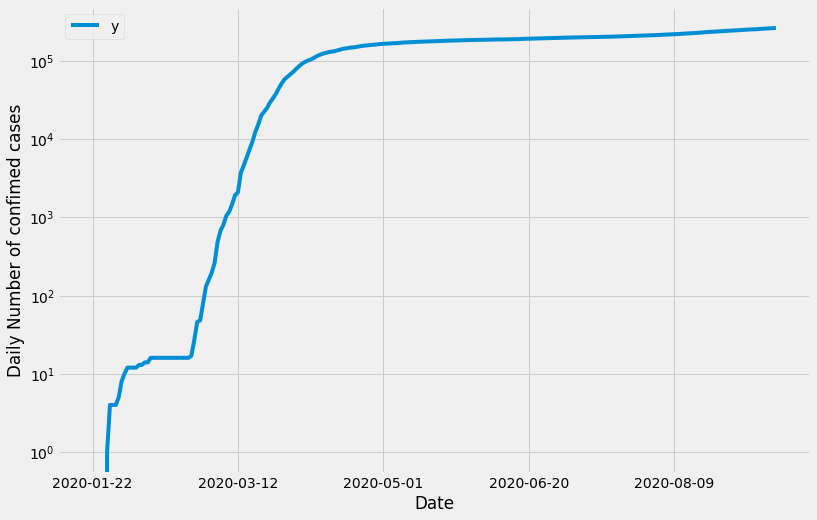

In [39]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()


In [40]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

#my_model = Prophet(interval_width=0.95) # piecwise linear model
my_model = Prophet(growth='logistic')   # logistic model

In [41]:
# the column 'cap' is only mandatory for the logistic model
df['cap']=1000000.
my_model.fit(df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/tk/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [42]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
238,2020-09-16,1000000.0
239,2020-09-17,1000000.0
240,2020-09-18,1000000.0
241,2020-09-19,1000000.0
242,2020-09-20,1000000.0


In [43]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)

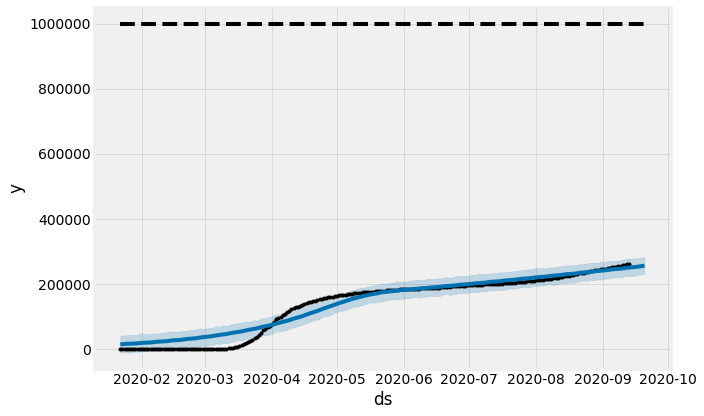

In [44]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [45]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [46]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,15006.386192,1000000.0,-10698.607289,41879.363084,15006.386192,15006.386192,-407.251326,-407.251326,-407.251326,-407.251326,-407.251326,-407.251326,0.0,0.0,0.0,14599.134867
1,2020-01-23,15363.227767,1000000.0,-9701.439373,41627.969159,15363.227767,15363.227767,-56.283805,-56.283805,-56.283805,-56.283805,-56.283805,-56.283805,0.0,0.0,0.0,15306.943961
2,2020-01-24,15728.419293,1000000.0,-7969.527564,41472.953277,15728.419293,15728.419293,371.436911,371.436911,371.436911,371.436911,371.436911,371.436911,0.0,0.0,0.0,16099.856204
3,2020-01-25,16102.149642,1000000.0,-11370.154625,42683.404574,16102.149642,16102.149642,347.029880,347.029880,347.029880,347.029880,347.029880,347.029880,0.0,0.0,0.0,16449.179522
4,2020-01-26,16484.611644,1000000.0,-11375.113996,43811.050716,16484.611644,16484.611644,158.013812,158.013812,158.013812,158.013812,158.013812,158.013812,0.0,0.0,0.0,16642.625456


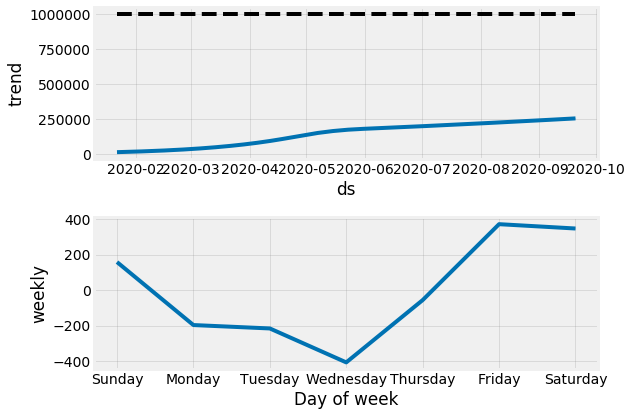

In [47]:
my_model.plot_components(forecast);

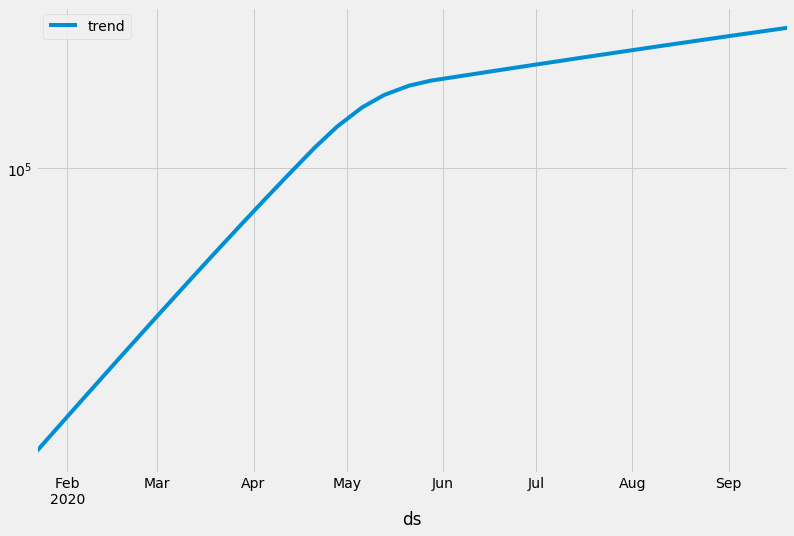

In [48]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross-Validation

In [49]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

INFO:fbprophet:Making 189 forecasts with cutoffs between 2020-03-02 00:00:00 and 2020-09-06 00:00:00
/home/tk/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [50]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,86.586943,83.891047,89.288841,196,2020-03-02
1,2020-03-04,-20.144983,-22.752362,-17.489966,262,2020-03-02
2,2020-03-05,-18.452308,-21.051246,-15.834211,482,2020-03-02
3,2020-03-06,-17.478735,-20.136014,-14.679255,670,2020-03-02
4,2020-03-07,-14.132401,-16.636809,-11.426054,799,2020-03-02


In [51]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [52]:
# the performance matrix shows the result for all horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.388501e+09,37262.594888,28709.674452,0.186829,0.221297,0.301587
1,2 days,1.638834e+09,40482.518831,31710.241747,0.215164,0.262755,0.296296
2,3 days,1.937607e+09,44018.256945,34958.140648,0.242607,0.308568,0.296296
3,4 days,2.296160e+09,47918.260162,38476.638802,0.272036,0.339937,0.291005
4,5 days,2.728497e+09,52235.021457,42310.339941,0.302619,0.369228,0.291005
5,6 days,3.253353e+09,57038.170528,46487.573822,0.336573,0.397355,0.291005
6,7 days,3.894907e+09,62409.188457,51052.850737,0.372578,0.419256,0.291005


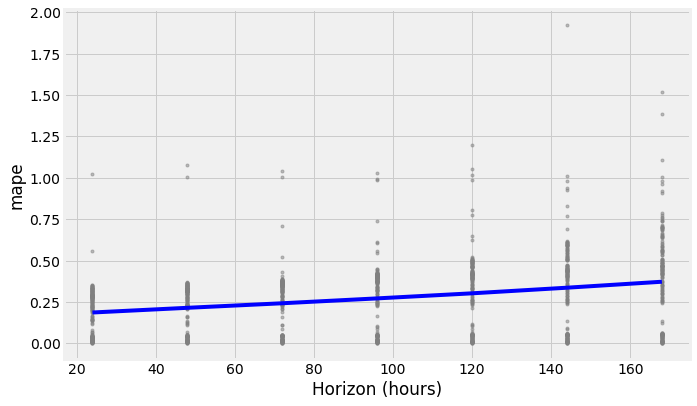

In [53]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonalplot 

### gives a good understanding for the under and over estimation w.r.t. magnitude 

In [54]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [55]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1294,2020-09-09,241171.788065,218227.089063,264598.443625,256433,2020-09-02,7 days
1301,2020-09-10,243893.803777,217309.442531,270366.530942,258149,2020-09-03,7 days
1308,2020-09-11,244353.582010,219215.499218,267520.592175,259735,2020-09-04,7 days
1315,2020-09-12,246666.703551,219175.344072,274105.170651,260817,2020-09-05,7 days
1322,2020-09-13,246144.146861,221480.001100,269223.929811,261737,2020-09-06,7 days


In [56]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

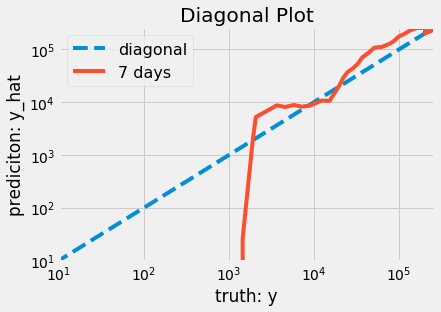

In [57]:

fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

 Example trivial forecast, prediciton 7 days into the future

In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [59]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

### One of the standard forecast is a rolling mean 

An other standard forecast is the exponentially-weighted moving average,
see pandas.ewma

In [60]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [61]:
# the result has to be shifted according to the prediciton horizon (here 7 days)

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 127.6807888473055


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000,NaT,NaN,NaT
3,2020-01-25,0,0.000000,NaT,NaN,NaT
4,2020-01-26,0,0.000000,NaT,NaN,NaT
5,2020-01-27,1,0.333333,NaT,NaN,NaT
6,2020-01-28,4,1.666667,NaT,NaN,NaT
7,2020-01-29,4,3.000000,2020-01-22,NaN,7 days
8,2020-01-30,4,4.000000,2020-01-23,NaN,7 days
9,2020-01-31,5,4.333333,2020-01-24,0.000000,7 days
